# GTEX Attenuation Bias
#### Exploring the attenuation bias by comparing the predicted values of GTEX using Predixcan to measured values of GTEX

In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [75]:
import pandas as pd
import numpy as np
import gzip
import sys
import os
import seaborn as sns

In [115]:
import mediator_was.processing.gtex as gtex
import mediator_was.processing.predixcan as predixcan
import mediator_was.modeling as modeling

#### Load data

In [81]:
measured = gtex.load_expression()
predicted = "../../data/predixcan/predictions.minus-hla.alpha0.5.tsv.gz"
predicted = predixcan.load_predicted(predicted)
merged = modeling.helpers.merge_dfs(measured, predicted)

In [80]:
merged.head(6).T.head().T

GTEX-111YS  GTEX-1122O  GTEX-1128S  GTEX-113IC  GTEX-113JC
name                                                                        
UBE2Q1 Measured     1.060130    0.823842   -2.753304    0.296352   -1.003470
       Predicted   -0.010762    0.085950    0.092746   -0.041396    0.022508
RNF14  Measured     0.635544   -0.055485   -0.714487    0.463414   -1.397571
       Predicted   -0.152526   -0.358662   -0.345056   -0.358662   -0.337245
UBE2Q2 Measured    -0.564709   -0.728877    0.025883    1.672655    0.447011
       Predicted   -0.014471    0.049872    0.184232    0.140187    0.231712

##### Recreate correlation figure 5 from paper. 

In [68]:
paper_genes = ['ERAP2', 'NUDT2', 'PEX6', 'ERAP1']

Find correlations between measured and predicted

In [116]:
modeling.helpers.calculate_correlations(merged, paper_genes)

,ERAP2,NUDT2,PEX6,ERAP1
Correlation,0.676233,0.462116,0.560373,0.288723


Plot the paper figure vs our figure

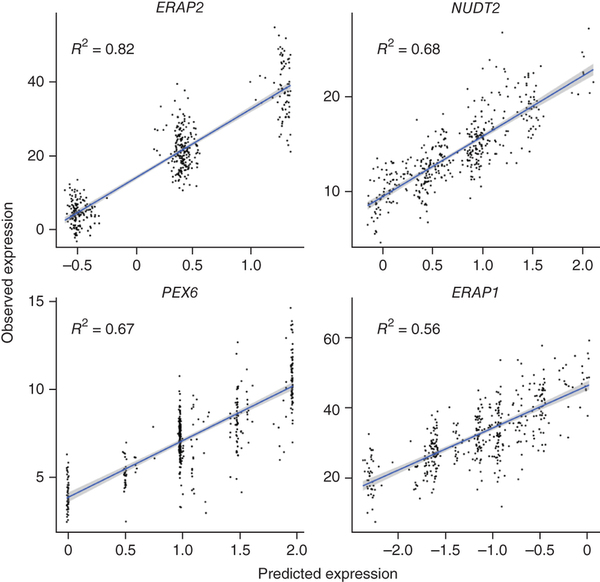

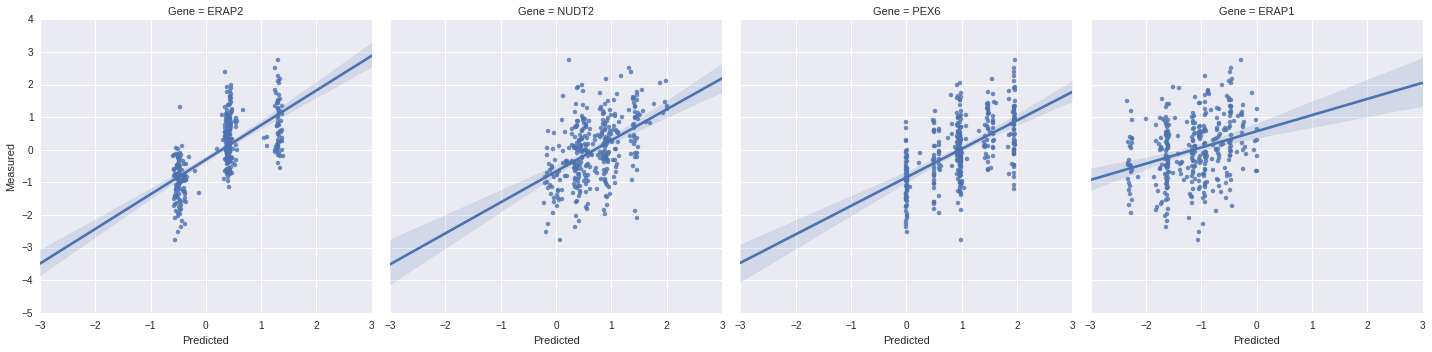

In [70]:
ax = modeling.plotting.multi_gene_plot(merged,paper_genes)
from IPython.display import Image
Image('http://www.nature.com/ng/journal/v47/n9/images_article/ng.3367-F5.jpg', height="300", width="300")

#### Quick look shows that the scale of the two values are different, however the general trends remain the same. The correlations are a bit lower than the paper correlations as well. However, I believe the paper figure is from the Geuvadis dataset. 

##### Standardizing predicted and measured

One way to better compare the two samples and to calculate the residual of measured-predicted is to first standardize the variables. 

TODO: 
* Read more about if standardizing this way is kosher for comparing residuals
* How does this affect the next stage of regressing on the phenotype

### Using already quantile normalized + standardized GTEX values

According to http://www.gtexportal.org/home/documentationPage, the processing steps included:
* Quantile normalization was performed within each tissue to bring the expression profile of each sample onto the same scale.
* To protect from outliers, inverse quantile normalization was performed for each gene, mapping each set of expression values to a standard normal.

As such, it would be reasonable to standardize the predicted values and look at the differences.

#### First, confirm that measured values are standardized

In [91]:
measured_stats = pd.concat([measured.mean(axis=1).describe(), 
                             measured.std(axis=1).describe()],
                           axis=1)
measured_stats.columns = ['Mean', 'Standard Deviation']
measured_stats.T

,count,mean,std,min,25%,50%,75%,max
Mean,23305,0.000201,0.000874,-0.067543,-3.927854e-07,8.988544e-09,0.000001,0.005829
Standard Deviation,23305,0.985989,0.004320,0.530448,9.866142e-01,9.866308e-01,0.986632,0.986633


Looks Good.

#### Standardize predicted values

In [104]:
predicted_standardized = predicted.apply(lambda x: (x-x.mean())/x.std(), axis=1)

In [106]:
predicted_stats = pd.concat([predicted_standardized.mean(axis=1).describe(), 
                             predicted_standardized.std(axis=1).describe()],
                           axis=1)
predicted_stats.columns = ['Mean', 'Standard Deviation']
predicted_stats.T

,count,mean,std,min,25%,50%,75%,max
Mean,11447,1.692430e-17,1.973674e-15,-2.296632e-14,-3.990635e-16,5.427757e-18,4.232417e-16,3.854867e-14
Standard Deviation,11447,1.000000e+00,1.023982e-15,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


Looks good.

In [113]:
standardized = modeling.helpers.merge_dfs(measured, predicted_standardized)

#### Let's replot Figure 5 to make sure

In [117]:
modeling.helpers.calculate_correlations(standardized, paper_genes)

,ERAP2,NUDT2,PEX6,ERAP1
Correlation,0.676233,0.462116,0.560373,0.288723


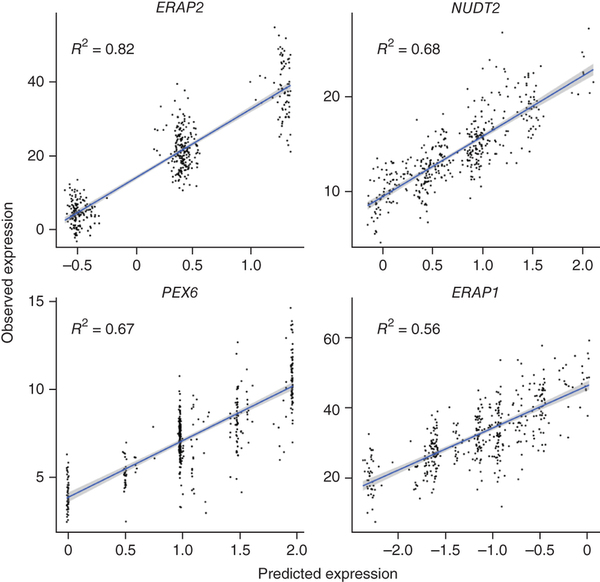

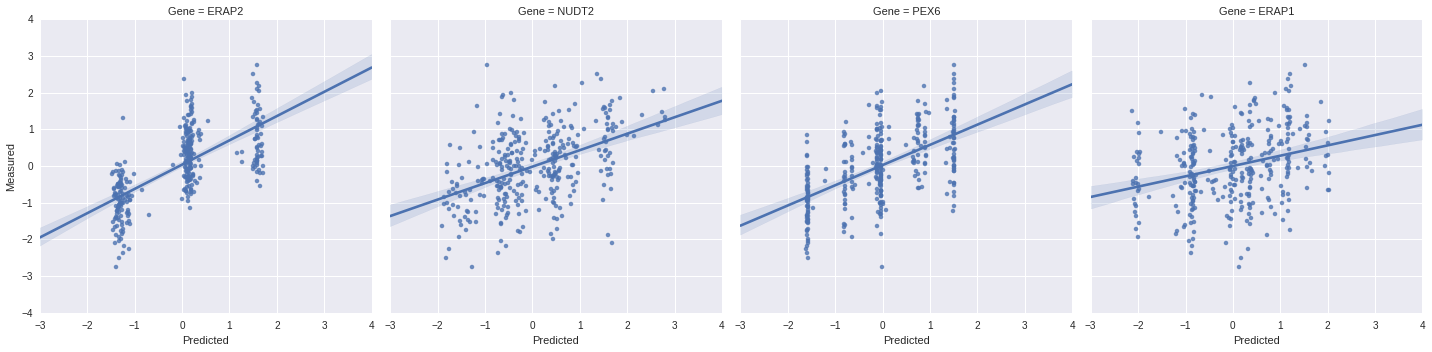

In [114]:
ax = modeling.plotting.multi_gene_plot(standardized, paper_genes)
from IPython.display import Image
Image('http://www.nature.com/ng/journal/v47/n9/images_article/ng.3367-F5.jpg', height="300", width="300")

### Using non-normalized, but covariate-corrected GTEX values

##### Attenuation Bias

One can define attenuation bias $\lambda$ two ways according to [ref][https://en.wikipedia.org/wiki/Errors-in-variables_models]:


$$\begin{equation}
    \lambda = \frac{\sigma^2_{measured}}{( \sigma^2_{residuals} + \sigma^2_{measured})}
 \end{equation}
$$

<br><center>or</center> 

$$\begin{equation}
    \lambda = \frac{(\sigma^2_{predicted} - \sigma^2_{residuals})}{\sigma^2_{predicted}}
 \end{equation},
 \text{when you know } \sigma^2_{residuals} \text{ a priori} 
$$

#### Calculating the $\sigma^2_{residuals}$

In [111]:
residuals = standardized.loc(axis=0)[:,'Measured']
residuals -= standardized.loc(axis=0)[:,'Predicted'].values
residuals.index = residuals.index.droplevel(1)
residuals.head()

,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,GTEX-117XS,GTEX-117YW,GTEX-1192W,GTEX-11DXW,GTEX-11DXX,...,GTEX-ZVE2,GTEX-ZVP2,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVTK,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5
name,,,,,,,,,,,,,,,,,,,,,
UBE2Q1,1.647600,0.177711,-3.486120,1.274573,-0.840364,-1.577776,-1.129347,-2.244430,0.576410,1.513666,...,-1.173734,-0.352774,-0.621072,-1.529691,-0.523623,-0.622869,0.615916,0.705929,1.708760,1.172234
RNF14,-0.167831,0.924306,0.147606,1.443205,-0.603052,-0.886884,-2.564596,-0.540730,-0.635745,1.074409,...,2.147786,1.448173,0.936732,0.211315,-1.261013,-0.673351,0.198138,-0.850234,0.799129,0.181633
UBE2Q2,0.786845,0.099812,-0.237260,1.767431,-0.201967,-0.424563,-0.322893,0.193990,0.413806,0.509064,...,-1.270630,1.513070,0.429312,2.226702,-0.493405,1.119671,-1.540111,-0.404031,0.328045,1.475331
RNF10,-0.590723,0.501767,2.143855,-1.096919,0.501224,0.216878,-2.916557,-2.427608,-2.096028,0.574174,...,1.514459,0.381286,0.875035,-1.813210,-1.744732,-1.072237,-0.375021,-2.130849,-1.506626,-1.676416
RNF13,1.088974,0.952712,-1.940795,0.209774,1.372446,-1.256051,-1.115812,-1.945804,-0.813763,2.350437,...,0.092541,1.069570,0.757055,0.038536,-0.559772,0.276568,1.052316,-1.776587,1.594837,0.554263


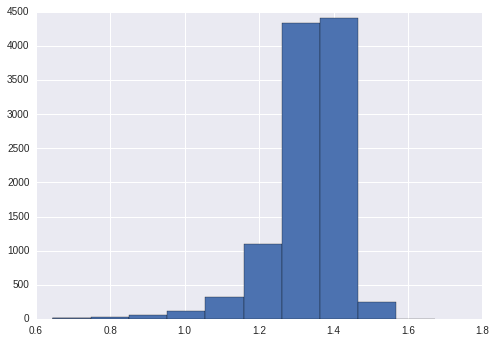

In [112]:
residuals.std(axis=1).hist()

The residuals are too high. This means that there is a std deviation difference between measured and predicted. Let's look at the paper genes again as our gold standard.

In [118]:
residuals.std(axis=1).ix[paper_genes]

name
ERAP2    0.803008
NUDT2    1.038774
PEX6     0.933472
ERAP1    1.192946
dtype: float64

That's pretty high. Let's see how the lowest standard deviations look.

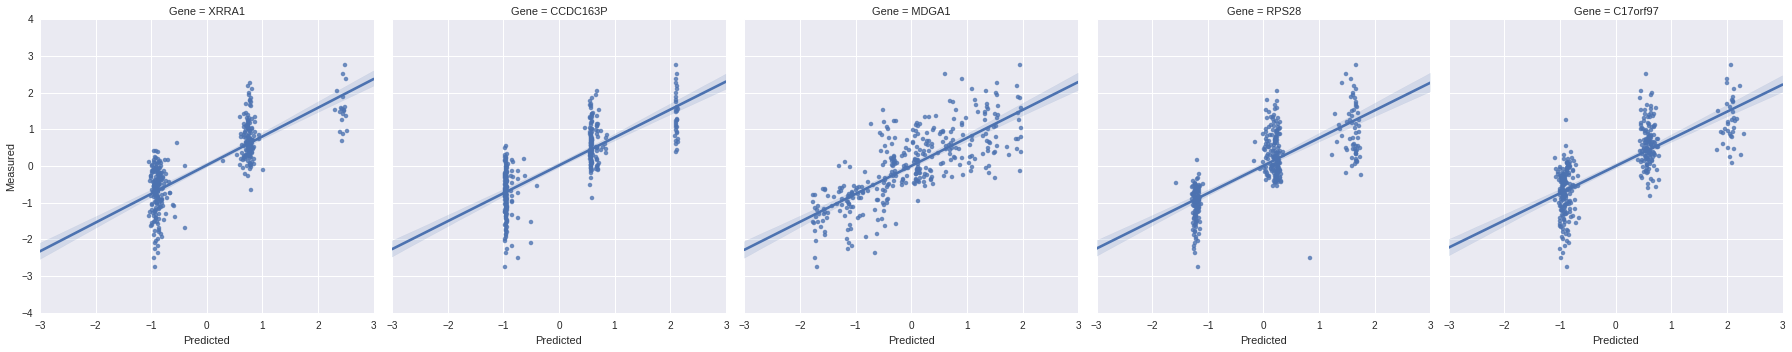

In [124]:
residuals_stds = residuals.std(axis=1)
residuals_stds.sort()
modeling.plotting.multi_gene_plot(standardized, residuals_stds.head().index)

And highest.

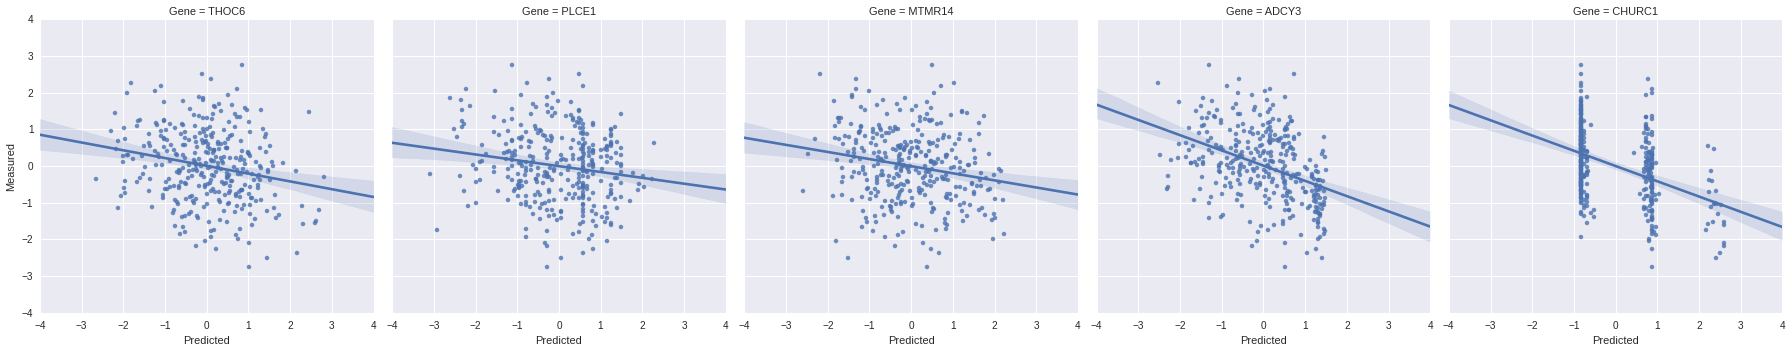

In [126]:
modeling.plotting.multi_gene_plot(standardized, residuals_stds.tail().index)

#### This does not seem to be a good measure.

TODO: 
* Dissect mathematically why this does or does not make sense
* Show how this impacts the calculation downstream.
    * Simulation study showing how real measured effect sizes vs predicted effect sizes and their impact.

# Changing the mean because of scaling. Instead of looking at Var(Measured - Predicted), look at Var(Measured - W*Predicted)

i.e.

First fit, M = W*P + e, then look at the variance of e

#### So far, so good in terms of our estimation. Let's fit linear models and save the results.'

In [159]:
import statsmodels.api as sm

In [208]:
# Toy example
gene = 'ERAP2'
model = sm.OLS(combined.ix[gene,'Measured'], combined.ix[gene, 'Predicted'])
results = model.fit()
print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     ('ERAP2', 'Measured')   R-squared:                       0.194
Model:                               OLS   Adj. R-squared:                  0.191
Method:                    Least Squares   F-statistic:                     80.87
Date:                   Sun, 25 Oct 2015   Prob (F-statistic):           1.77e-17
Time:                           14:36:17   Log-Likelihood:                -438.20
No. Observations:                    338   AIC:                             878.4
Df Residuals:                        337   BIC:                             882.2
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------

In [211]:
np.std(results.resid)

0.8211695755782715

In [210]:
coefficients = {}
coefficients[gene] = (results.params, results.bse)
residuals = {}
residuals[gene] = results.resid

In [187]:
coefficients, residuals[gene].head()

({'ERAP2': ((ERAP2, Predicted)    0.448616
   dtype: float64, (ERAP2, Predicted)    0.049886
   dtype: float64)}, GTEX-111YS   -1.023571
 GTEX-1122O   -0.802536
 GTEX-1128S    0.626108
 GTEX-113IC    0.078283
 GTEX-113JC    0.747230
 dtype: float64)

In [218]:
genes = combined.index.get_level_values(0)
coefficients = {}
residuals = {}

In [223]:
results.params.values[0]

0.2406357218570683

In [224]:
for gene in genes:
    model = sm.OLS(combined.ix[gene,'Measured'], combined.ix[gene, 'Predicted'])
    results = model.fit()
    coefficients[gene] = (results.params.values[0], results.bse.values[0])
    residuals[gene] = results.resid

In [194]:
residuals_df = pd.DataFrame.from_dict(residuals, orient='index')

In [195]:
residuals_df.head()

,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,GTEX-117XS,GTEX-117YW,GTEX-1192W,GTEX-11DXW,GTEX-11DXX,...,GTEX-ZVE2,GTEX-ZVP2,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVTK,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5
A2M,-0.771344,-0.496332,-0.847411,-2.262840,0.905703,0.671178,-0.257638,0.299022,0.123698,-1.095567,...,0.307705,-1.004540,-0.982902,-0.247152,-0.174039,-0.870201,-0.682609,0.346787,-1.422883,-1.872697
A4GALT,-0.122091,-1.437904,-0.053141,-2.050005,-0.059717,1.483174,0.743860,0.747602,1.616211,-2.352712,...,0.951563,0.106473,-0.820637,0.144646,1.461991,0.520282,-0.503730,1.537048,-0.964963,-1.814097
AACS,0.037066,-1.406510,2.349426,0.001322,-0.535400,1.128191,1.843245,0.393010,0.735432,-1.541961,...,-1.268252,0.930749,-0.105887,0.498033,0.173543,1.304295,0.036786,1.375711,-0.711217,0.339407
AAGAB,0.323449,-0.051377,0.742155,1.852680,-1.976394,1.133901,-1.689061,-0.647370,-0.822713,-0.119795,...,0.140539,0.351868,0.180166,-0.444178,-1.235864,-0.757682,-0.815730,-0.311517,-0.660435,-0.032568
AAK1,-0.994842,-0.340208,2.697165,-0.654927,0.846673,1.041740,2.089583,0.597043,0.412951,0.098977,...,-0.226689,-1.177864,-0.975821,0.698634,0.725276,1.843311,-0.787137,0.475732,-0.786493,1.274875


In [212]:
std_errors = residuals_df.std(axis=1)
std_errors.sort()

In [213]:
std_errors.head()

HBA2       0.682191
XRRA1      0.688829
CPA5       0.694524
SLC12A1    0.700996
AFAP1      0.706581
dtype: float64

In [214]:
std_errors.tail()

KDM2B       0.986633
LIPH        0.986633
ABCD2       0.986633
INCENP      0.986633
SLC16A14    0.986633
dtype: float64

### Why do multiple genes have the same standard error and why is it bounded to 0.986 (bounded most likely because of normalization step by GTEX)?

### Lowest standard deviations

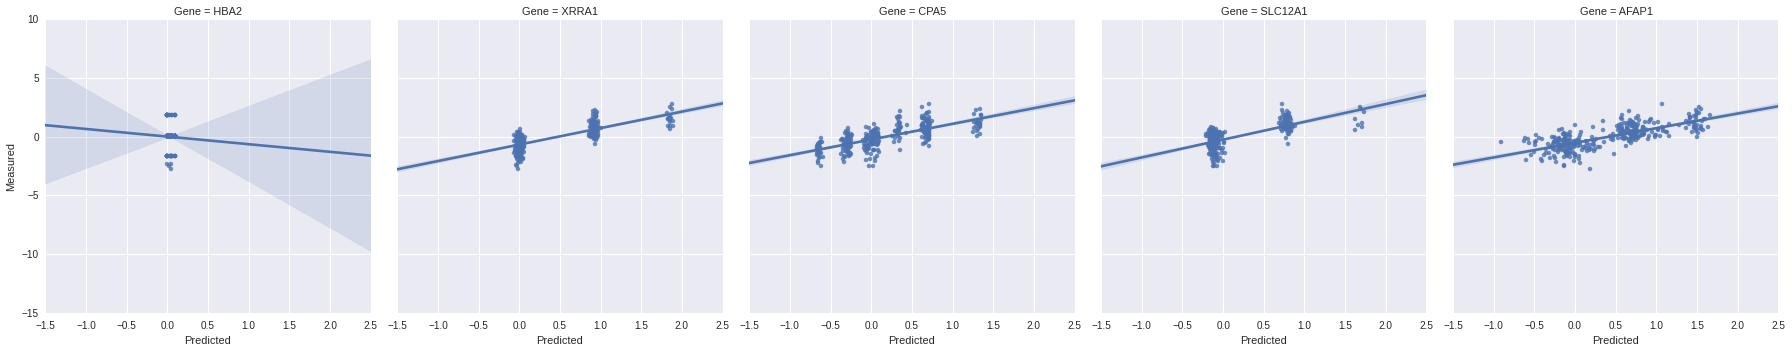

In [263]:
multi_gene_plot(std_errors.head().index)

### Highest standard deviations

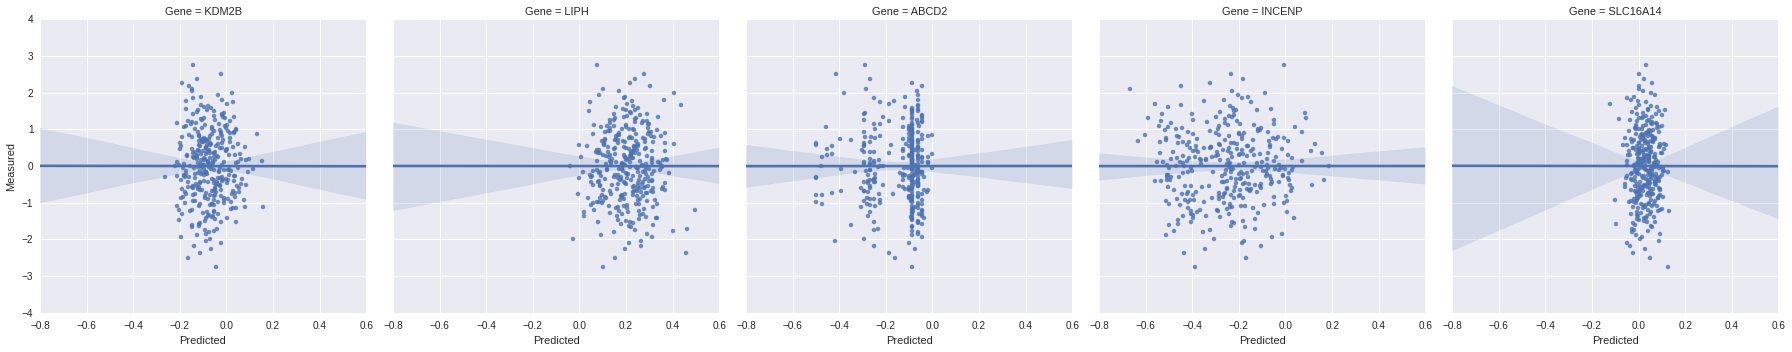

In [264]:
multi_gene_plot(std_errors.head().index)

#### Combine coef, std error on coef, and residual std.

In [229]:
combined_df = pd.concat([pd.DataFrame(coefficients), pd.DataFrame(std_errors).T])
combined_df.index = ['Coefficient', 'SE-Coef', 'SD-Residuals']

In [230]:
combined_df

,A2M,A4GALT,AACS,AAGAB,AAK1,AAMP,AANAT,AARS,AARS2,AARSD1,...,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZWILCH,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
Coefficient,0.025215,0.482674,-0.071435,0.179356,-1.603465,0.010884,0.222718,1.161682,0.110487,-0.020868,...,0.141873,0.346763,-1.079445,0.714465,-0.014104,0.446673,0.481809,0.239906,-0.170556,-0.123236
SE-Coef,0.174900,0.091171,0.210400,0.428029,1.237511,0.450089,0.091992,1.462688,0.445290,0.378384,...,0.304549,1.267211,0.725990,0.698448,0.711294,0.414923,0.276897,0.085134,0.432879,0.942281
SD-Residuals,0.986583,0.929124,0.986380,0.986217,0.984121,0.986629,0.972074,0.985114,0.986500,0.986625,...,0.986304,0.986494,0.981833,0.984678,0.986632,0.984122,0.981343,0.966543,0.986339,0.986600


#### Let's add information about the variance of the predictions

In [238]:
std_predictors = pd.DataFrame(predicted.std(axis=1)).T
std_predictors.index = ['SD-Prediction']

In [239]:
combined_df = pd.concat([combined_df, std_predictors])

In [242]:
combined_df.dropna(axis=1)

,A2M,A4GALT,AACS,AAGAB,AAK1,AAMP,AANAT,AARS,AARS2,AARSD1,...,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZWILCH,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
Coefficient,0.025215,0.482674,-0.071435,0.179356,-1.603465,0.010884,0.222718,1.161682,0.110487,-0.020868,...,0.141873,0.346763,-1.079445,0.714465,-0.014104,0.446673,0.481809,0.239906,-0.170556,-0.123236
SE-Coef,0.174900,0.091171,0.210400,0.428029,1.237511,0.450089,0.091992,1.462688,0.445290,0.378384,...,0.304549,1.267211,0.725990,0.698448,0.711294,0.414923,0.276897,0.085134,0.432879,0.942281
SD-Residuals,0.986583,0.929124,0.986380,0.986217,0.984121,0.986629,0.972074,0.985114,0.986500,0.986625,...,0.986304,0.986494,0.981833,0.984678,0.986632,0.984122,0.981343,0.966543,0.986339,0.986600
SD-Prediction,0.184727,0.417982,0.185680,0.077466,0.042314,0.064178,0.311882,0.021870,0.087731,0.075593,...,0.169779,0.037063,0.051641,0.063764,0.043674,0.093130,0.171103,0.329471,0.109996,0.058781


In [250]:
def calculate_reliability_ratio(series):
    variance_x = np.power(series['SD-Prediction'], 2)
    variance_error = np.power(series['SD-Residuals'], 2)
    return (variance_x - variance_error) / variance_x

In [252]:
combined_df.ix['Reliability-Ratio'] = combined_df.apply(calculate_reliability_ratio)

In [256]:
reliability_ratio = combined_df.ix['Reliability-Ratio'].map(abs)
reliability_ratio.sort()

In [266]:
combined_df[reliability_ratio.head().index]

,C17orf97,IGHMBP2,AFAP1,XRRA1,BEGAIN
Coefficient,0.700380,0.936774,0.827686,0.805848,0.431637
SE-Coef,0.055015,0.062696,0.059514,0.058596,0.048768
SD-Residuals,0.722190,0.712114,0.706581,0.688829,0.826293
SD-Prediction,0.605294,0.596348,0.582610,0.562772,0.645360
Reliability-Ratio,-0.423544,-0.425934,-0.470849,-0.498162,-0.639321


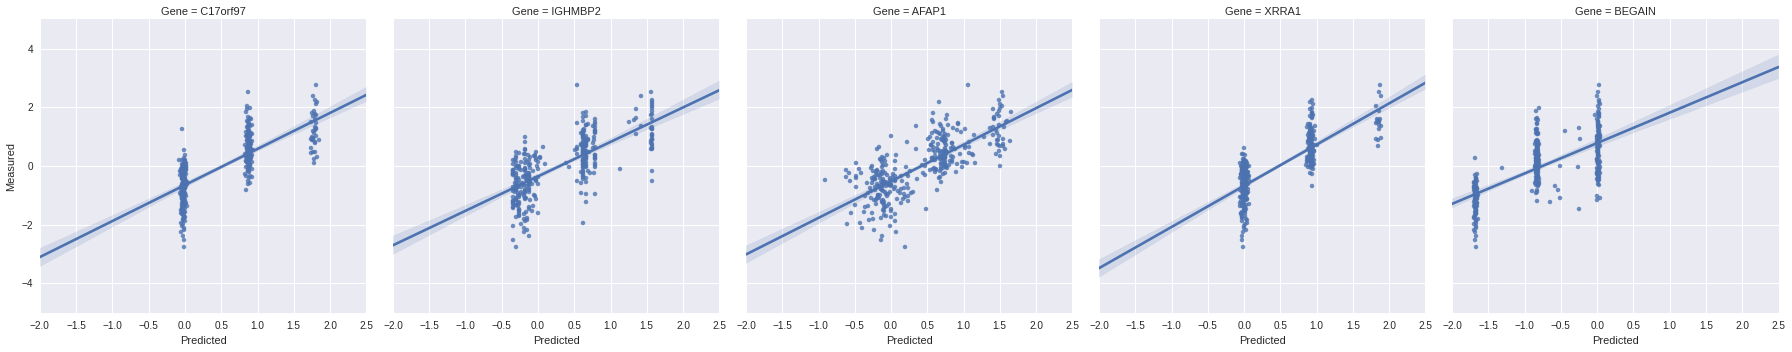

In [265]:
multi_gene_plot(reliability_ratio.head().index)

### Need to think about scale of these items

In [71]:
from IPython.core.display import HTML


def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()